In [143]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from nilearn.image import concat_imgs, mean_img
from nilearn.plotting import plot_stat_map, plot_design_matrix, plot_contrast_matrix
from nilearn.plotting import plot_anat, plot_img, show
from nilearn.glm.first_level import FirstLevelModel
from nilearn.reporting import get_clusters_table
from nilearn.glm import threshold_stats_img

from bids import BIDSLayout

In [4]:
# ACNets project folder (to access data and resources)
project_dir = Path('../..')

# you need to download preprocessed subject data before running the notebook:
# datalad get derivatives/fmriprep/sub-NVGP01* -r

In [9]:
layout = BIDSLayout(project_dir / 'data/julia2018',
                    derivatives=True,
                    database_path=project_dir / 'tmp/pybids_cache/julia2018')

task = 'attention'
sessions = ['1','2']
subjects = layout.get_subject()

func_images = layout.get(task=task,
                         desc='preproc',
                         subject=subjects,
                         session=sessions,
                         suffix='bold',
                         scope='fmriprep',
                         extension='nii.gz',
                         return_type='filename')

mask_images = layout.get(task=task,
                         desc='brain',
                         subject=subjects,
                         session=sessions,
                         suffix='mask',
                         scope='fmriprep',
                         extension='nii.gz',
                         return_type='filename')

confounds_files = layout.get(task=task,
                             desc='confounds',
                             subject=subjects,
                             session=sessions,
                             suffix='timeseries',
                             scope='fmriprep',
                             extension='tsv',
                             return_type='filename')

events_files = layout.get(task=task,
                          subject=subjects,
                          session=sessions,
                          suffix='events',
                          scope='self',
                          extension='tsv',
                          return_type='filename')


confounds_cols = ['trans_x', 'trans_y', 'trans_z',
                  'rot_x', 'rot_y', 'rot_z',
                  'global_signal',
                  'a_comp_cor_00', 'a_comp_cor_01']

TR = layout.get_tr(task=task,subject=subjects, session=sessions)


In [87]:
# %% load data for one subject (Note that subject and session are both in singluar)

session = '1'
subject = ['NVGP01']

anat_images = layout.get(subject=subject,
                         datatype='anat',
                         space='MNI152NLin2009cAsym',
                         desc='preproc',
                         suffix='T1w',
                         scope='fmriprep',
                         extension='nii.gz',
                         return_type='filename')

func_images = layout.get(task=task,
                         desc='preproc',
                         subject=subject,
                         session=session,
                         suffix='bold',
                         scope='fmriprep',
                         extension='nii.gz',
                         return_type='filename')

events_files = layout.get(task=task,
                          subject=subject,
                          session=session,
                          suffix='events',
                          scope='self',
                          extension='tsv',
                          return_type='filename')

confounds_files = layout.get(task=task,
                             subject=subject,
                             session=session,
                             desc='confounds',
                             suffix='timeseries',
                             scope='fmriprep',
                             extension='tsv',
                             return_type='filename')

def prep_events(df):
    df['trial_type'] = df['trial_type'] + '_' + df['event_type']
    return  df

events = [pd.read_table(ef).pipe(prep_events) for ef in events_files]
# # TODO filter events

confounds = [pd.read_table(cf)[confounds_cols] for cf in confounds_files]
# # TODO filter events


# apply Gaussian kernel of 8mm (foecker was 5mm) and band-pass filtering
# run-specific intercept
# convolve with canonical HRF
# GLM predictor = target onset of different trial types
# additional regressors = error, post-error, timeout, and outlier trials

# combine both sessions as foecker2018 found no relevant differences acorss sessions.
# analyze all trials (correct and incorrect)
# foecker2018 also used SOA as regressor
# Emiliano used 90-ROIs from Shirer for resting state https://findlab.stanford.edu/functional_ROIs.html
# a more comperhensive atlas would be willard which contains 499 ROIs
# Emiliano used filtering of ([0.008 0.09]) 

# planned contrasts:
#   - invalid vs valid
#   - left vs right ( * valid vs invalid)
#   - interaction of cue vs target_position
#   - distractors????


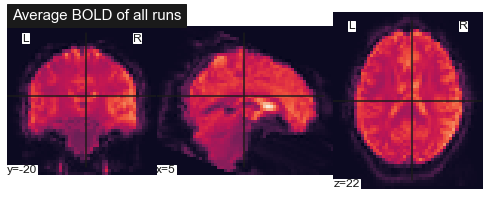

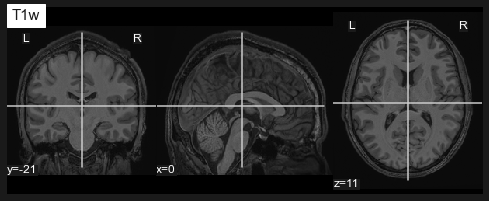

In [128]:
# all_fun_images = concat_imgs(fmri_images)
bg_image = mean_img(func_images)
plot_img(bg_images[0], title='Average BOLD of all runs')
plot_anat(anat_images[0], title='T1w')

show()


In [129]:
# fit GLM

fmri_glm = FirstLevelModel(t_r=TR,
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01,
                           subject_label=subjects)

fmri_glm = fmri_glm.fit(func_images, events=events, confounds=confounds)


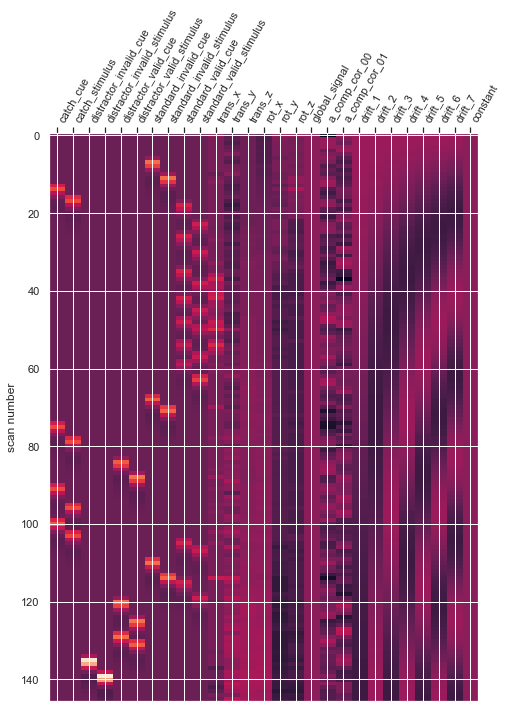

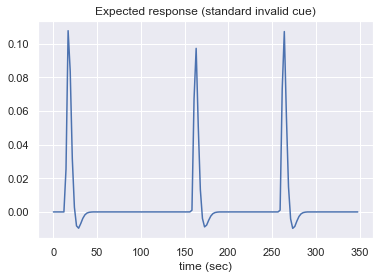

In [130]:
# plot design matrix
# row=time, col=predictors
run1_design_matrix = fmri_glm.design_matrices_[0]

plot_design_matrix(run1_design_matrix)
show()

plt.plot(run1_design_matrix['standard_invalid_cue'])
plt.xlabel('time (sec)')
plt.title('Expected response (standard invalid cue)')

show()

In [131]:
# # calculate contrast matrix

# HARD WAY
# conditions = {
#     'valid':   np.array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
#     'invalid': np.array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
# }

# contrast = np.tile(conditions['valid'] - conditions['invalid'], (8, 1))
# contrast = conditions['valid'] - conditions['invalid']


contrast = '(standard_valid_stimulus + distractor_valid_stimulus) - (standard_invalid_stimulus + distractor_invalid_stimulus)'

#  same for the all runs
contrast = [contrast] * 8

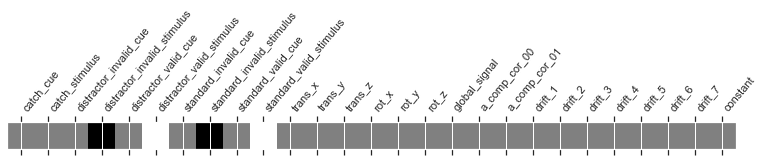

In [132]:
# plot contrast matrix of the first run (for all runs is the same as this)

plot_contrast_matrix(contrast[0], design_matrix=run1_design_matrix)
plt.show()

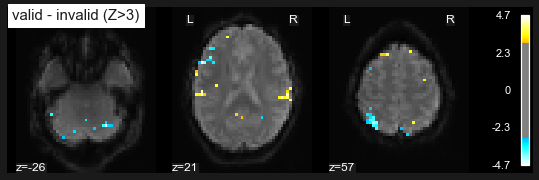

In [135]:
# effect size map, z map, and plot them
# eff_map = fmri_glm.compute_contrast(contrast, output_type='effect_size')

z_map = fmri_glm.compute_contrast(contrast, output_type='z_score')

plot_stat_map(z_map, bg_img=bg_image, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='valid - invalid (Z>3)')
plt.show()

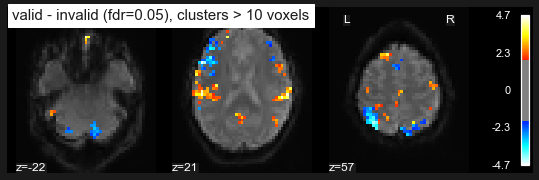

   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1 -68.5 -20.5  17.5   4.660677              12352
1          1a -56.5 -24.5  21.5   4.471790                   
2          1b -68.5 -12.5  25.5   4.447720                   
3          1c -52.5 -32.5  17.5   3.946999                   
4           2  51.5 -20.5  17.5   4.559932              15680
5          2a  63.5 -12.5  17.5   4.501527                   
6          2b  63.5 -24.5  21.5   4.467590                   
7          2c  55.5 -28.5  21.5   4.450050                   
8           3 -64.5   7.5  17.5   4.460330               1344
9           4  27.5 -36.5  69.5   4.393265               1984
10         4a  27.5 -44.5  73.5   3.863237                   
11         4b  23.5 -52.5  73.5   3.012917                   
12          5  35.5   7.5   1.5   4.281536                192
13          6  -0.5  55.5 -22.5   4.205089                704
14         6a   3.5  51.5 -14.5   3.611718                   
15      

In [172]:
# print clusters info and coordinates

clean_map, threshold = threshold_stats_img(z_map,
                                           alpha=.05,
                                           height_control='fpr', # fdr, fpr, bonferroni
                                           cluster_threshold=10)

plot_stat_map(clean_map, bg_img=bg_image, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='valid - invalid (fpr=0.05), clusters > 10 voxels')
show()

clusters_table = get_clusters_table(z_map, stat_threshold=threshold).head(30)
print(clusters_table)